In [6]:
import numpy as np
import sys
import os 
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import basinhopping, minimize

import matplotlib.patches as patches
from matplotlib.pyplot import cm

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

# from aodfunctions.dependencies import *
# from aodfunctions.general import *
# from aodfunctions.testbed import *
# from aodfunctions.settings import *

from concurrent.futures import ThreadPoolExecutor, as_completed, ProcessPoolExecutor

import ipyparallel as ipp



from scipy.special import binom
def Bernstein_Poly(x, n, i):
    return binom(n,i) * x**i * (1-x)**(n-i)


In [7]:

def heuristic_3D_force(atom_loc,ideal_depth,xc,trap_rayleigh,trap_rad,trap_xfocalshift):
    [x,y,z] = atom_loc
    rad_y = trap_rad * np.sqrt(1+(z/trap_rayleigh)**2)
    rad_x = trap_rad * np.sqrt(1+((z-trap_xfocalshift)/trap_rayleigh)**2)
    normalized_intensity = np.exp(-2*(x-xc)**2/rad_x**2)*np.exp(-2*y**2/rad_y**2)*trap_rad**2/(rad_x*rad_y)
    normalized_force_x = normalized_intensity * (4*(x-xc)/rad_x**2)
    normalized_force_y = normalized_intensity * (4*y/rad_y**2)
    temp_A = z/(trap_rayleigh**2+z**2)
    temp_B = (z-trap_xfocalshift)/(trap_rayleigh**2+(z-trap_xfocalshift)**2)
    temp_C = temp_A*(1-4*y**2/rad_y**2) + temp_B*(1-4*(x-xc)**2/rad_x**2)
    normalized_force_z = normalized_intensity * temp_C
    return -ideal_depth * np.array([normalized_force_x,normalized_force_y,normalized_force_z])


def heuristic_3D_potential(atom_loc,ideal_depth,trap_x,trap_rayleigh,trap_rad,trap_xfocalshift):
    [x,y,z] = atom_loc
    rad_y = trap_rad * np.sqrt(1+(z/trap_rayleigh)**2)
    rad_x = trap_rad * np.sqrt(1+((z-trap_xfocalshift)/trap_rayleigh)**2)
    normalized_intensity = np.exp(-2*(x-trap_x)**2/rad_x**2)*np.exp(-2*y**2/rad_y**2)*trap_rad**2/(rad_x*rad_y)
    return -ideal_depth * normalized_intensity


def Bernstein_Poly(x, n, i):
    return binom(n,i) * x**i * (1-x)**(n-i)
def dBernstein_Poly(x, n, i):
    return binom(n,i) * (i-n*x) * x**(i-1) * (1-x)**(n-i-1)
def ddBernstein_Poly(x, n, i):
    return binom(n,i) * (i**2+(n-1)*n*x**2+i*(-1-2*(n-1)*x)) * x**(i-2) * (1-x)**(n-i-2)
    

heuristic_force = heuristic_3D_force
heuristic_potential = heuristic_3D_potential

In [8]:
TRAP_DEPTH_MHz = 1e6 * 6.63e-34 #J for 1MHz trap
RB_MASS = 1.419E-25 #kg


## Setting constants
## time units are in us
## length units are in um
## mass units are in Rb mass
## trap depth/energy in units of Rb mass*(m/s)^2

F = 9000 #um
V = 650*10/7.5 #um/us
M = 1
E0 = 10 * TRAP_DEPTH_MHz / RB_MASS #ideal trap depth
NA = 0.5
W = 1/np.pi/NA*0.8 #um
ZR = W/NA

# L_range =  30 #um
# T_range = 121 #us
# dT = 0.1 #us

# t_list = np.arange(0,T_range+1e-6,dT)




In [9]:
v_vec = np.ones((3,10))
k = v_vec.shape[1]
vc_vec = np.stack((np.ones(3),) * k, axis=-1)
np.sum((v_vec-vc_vec)**2, axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:

def kinetic_energy(phase_vec):
    v_vec = phase_vec[-3:]
    return (M/2) * np.sum(v_vec**2, axis=0)

def kinetic_energy_movframe(phase_vec,vc_vec):
    v_vec = phase_vec[-3:]
    return (M/2) * np.sum((v_vec-vc_vec)**2, axis=0)

def potential_energy(t, phase_vec,coeff):
    r_vec = phase_vec[:3]
    trap_xfocalshift = Zx_func(t,coeff)
    xc = xc_func(t,coeff)
    return heuristic_potential(r_vec,E0,xc,ZR,W,trap_xfocalshift)

def potential_energy_t0(phase_vec):
    r_vec = phase_vec[:3]
    return heuristic_potential(r_vec,E0,0,ZR,W,0)

def total_energy_movframe(t, phase_vec,coeff):
    arr = dxc_func(t,coeff)
    vc_vec = np.vstack((arr, np.zeros((2, arr.shape[0]))))
    # print(f"kinetic shape = {kinetic_energy_movframe(phase_vec, vc_vec)[0].shape}")
    # print(f"potential shape = {potential_energy(t, phase_vec, coeff)[0].shape}")
    return kinetic_energy_movframe(phase_vec, vc_vec) + potential_energy(t, phase_vec, coeff)

def total_energy(t, phase_vec,coeff):
    return kinetic_energy(phase_vec) + potential_energy(t, phase_vec,coeff)

def total_energy_t0(phase_vec):
    return kinetic_energy(phase_vec) + potential_energy_t0(phase_vec)

########################## for sinesq ramp base ###########################
def xc_func_base(t):
    return (1-np.cos(t/T_range*np.pi))/2 * L_range
def dxc_func_base(t):
    return (np.pi/2) * np.sin(t/T_range*np.pi) * (L_range/T_range)
# def ddxc_func_base(t):
#     return (np.pi**2/2) * np.cos(t/T_range*np.pi) * (L_range/T_range**2)
######################################################################
########################## for sinc ramps base###########################
# def xc_func_base(t,n):
#     return (t/T_range - np.sin(t/T_range*2*n*np.pi)/(2*n*np.pi)) * L_range
# def dxc_func_base(t,n):
#     return (1-np.cos(t/T_range*2*n*np.pi)) * (L_range/T_range)
# def ddxc_func_base(t,n):
#     return (np.sin(t/T_range*2*n*np.pi)*(2*n*np.pi)) * (L_range/T_range**2)
######################################################################

########################## for expansion perturbation using Bernstein Polynomials #########################
# def xc_expand(t,n,HIGHEST_ORDER):
#     x = t/T_range
#     n_split = HIGHEST_ORDER+1
#     return Bernstein_Poly(x, n_split, n) * L_range
# def dxc_expand(t,n,HIGHEST_ORDER):
#     x = t/T_range
#     n_split = HIGHEST_ORDER+1
#     return dBernstein_Poly(x, n_split, n) * (L_range/T_range)

########################## for expansion perturbation using Bernstein Polynomials (no initial velocity) #########################
def xc_expand(t,n,HIGHEST_ORDER):
    x = t/T_range
    n_split = HIGHEST_ORDER+3
    return Bernstein_Poly(x, n_split, n+1) * L_range
def dxc_expand(t,n,HIGHEST_ORDER):
    x = t/T_range
    n_split = HIGHEST_ORDER+3
    return dBernstein_Poly(x, n_split, n+1) * (L_range/T_range)

def xc_func(t,coeff):
    # assert len(coeff) == HIGHEST_ORDER
    HIGHEST_ORDER = len(coeff)
    func_array = np.array([xc_expand(t,n,HIGHEST_ORDER) for n in range(1, HIGHEST_ORDER+1)])
    return coeff @ func_array +  xc_func_base(t)
def dxc_func(t,coeff):
    # assert len(coeff) == HIGHEST_ORDER
    HIGHEST_ORDER = len(coeff)
    func_array = np.array([dxc_expand(t,n,HIGHEST_ORDER) for n in range(1, HIGHEST_ORDER+1)])
    return coeff @ func_array + dxc_func_base(t)
# def ddxc_func(t,coeff):
#     # assert len(coeff) == HIGHEST_ORDER
#     HIGHEST_ORDER = len(coeff)
#     func_array = np.array([ddxc_expand(t,n,HIGHEST_ORDER) for n in range(1, HIGHEST_ORDER+1)])
#     return coeff @ func_array + ddxc_func_base(t)
def Zx_func(t,coeff):
    return (F/V) * dxc_func(t,coeff)
heuristic_force = heuristic_3D_force
heuristic_potential = heuristic_3D_potential

def time_derivative(t, phase_vec, coeff):
    # phase_vec = [x,y,z,vx,vy,vz]
    # potential_force_func(t, atom_loc)
    # fictitious_force_func(t)
    if len(phase_vec.shape) == 1 and phase_vec.shape == 6:
        r_vec = phase_vec[:3]
        v_vec = phase_vec[-3:]
        xc = xc_func(t,coeff)
        trap_xfocalshift = Zx_func(t,coeff)
        potential_force = heuristic_force(r_vec,1*E0,xc,ZR,W,trap_xfocalshift)
        a_vec = (1/M) * potential_force
        return np.concatenate([v_vec,a_vec])
    elif len(phase_vec.shape) == 2 and phase_vec.shape[0] == 6:
        k = phase_vec.shape[-1]
        r_vec = phase_vec[:3]
        v_vec = phase_vec[-3:]
        xc = xc_func(t,coeff)
        trap_xfocalshift = Zx_func(t,coeff)
        potential_force = heuristic_force(r_vec,E0,xc,ZR,W,trap_xfocalshift)
        a_vec = (1/M) * potential_force
        return np.concatenate([v_vec,a_vec])
    elif phase_vec.shape[0] % 6 == 0:
        # print("vectorized")
        k = phase_vec.shape[0] // 6
        r_vec = phase_vec[0:3*k].reshape(3,k)
        v_vec = phase_vec[-3*k:].reshape(3,k)
        xc = xc_func(t,coeff)
        trap_xfocalshift = Zx_func(t,coeff)
        potential_force = heuristic_force(r_vec,E0,xc,ZR,W,trap_xfocalshift)
        a_vec = (1/M) * potential_force
        return np.concatenate([v_vec.ravel(),a_vec.ravel()])
    else:
        print(f"phase_vec shape= {phase_vec.shape} incorrect!")
        return 

In [11]:



def loss_func(expand_param, N_particle, HIGHEST_ORDER, init_temp_coeff, T_range, L_range, temp_or_surv):
    #####################################################################
    # expand_param: the expansion coefficients on the selected base functions
    # N_particle: number of monte carlo simulations done in a batch
    # init_temp_coeff: initial particle energy, either Bolzmann or thin-shell distribution
    # T_range: ramp time in us
    # L_range: ramp distance in um
    # temp_or_surv: use 0 for optimizing final temperature; i for optimizing final survival; in between for weighted both
    #######################################################################
    
    init_temp = E0 * init_temp_coeff
    ########################## for sinesq ramp base ###########################
    def xc_func_base(t):
        return (1-np.cos(t/T_range*np.pi))/2 * L_range
    def dxc_func_base(t):
        return (np.pi/2) * np.sin(t/T_range*np.pi) * (L_range/T_range)
    ######################################################################

    ########################## for expansion perturbation using Bernstein Polynomials #########################
    # def xc_expand(t,n,HIGHEST_ORDER):
    #     x = t/T_range
    #     n_split = HIGHEST_ORDER+1
    #     return Bernstein_Poly(x, n_split, n) * L_range
    # def dxc_expand(t,n,HIGHEST_ORDER):
    #     x = t/T_range
    #     n_split = HIGHEST_ORDER+1
    #     return dBernstein_Poly(x, n_split, n) * (L_range/T_range)
    
    ########################## for expansion perturbation using Bernstein Polynomials (no initial velocity) #########################
    def xc_expand(t,n,HIGHEST_ORDER):
        x = t/T_range
        n_split = HIGHEST_ORDER+3
        return Bernstein_Poly(x, n_split, n+1) * L_range
    def dxc_expand(t,n,HIGHEST_ORDER):
        x = t/T_range
        n_split = HIGHEST_ORDER+3
        return dBernstein_Poly(x, n_split, n+1) * (L_range/T_range)

    def xc_func(t,coeff):
        assert len(coeff) == HIGHEST_ORDER
        # HIGHEST_ORDER = len(coeff)
        func_array = np.array([xc_expand(t,n,HIGHEST_ORDER) for n in range(1, HIGHEST_ORDER+1)])
        return coeff @ func_array +  xc_func_base(t)
    def dxc_func(t,coeff):
        assert len(coeff) == HIGHEST_ORDER
        # HIGHEST_ORDER = len(coeff)
        func_array = np.array([dxc_expand(t,n,HIGHEST_ORDER) for n in range(1, HIGHEST_ORDER+1)])
        return coeff @ func_array + dxc_func_base(t)
    # def ddxc_func(t,coeff):
    #     # assert len(coeff) == HIGHEST_ORDER
    #     HIGHEST_ORDER = len(coeff)
    #     func_array = np.array([ddxc_expand(t,n,HIGHEST_ORDER) for n in range(1, HIGHEST_ORDER+1)])
    #     return coeff @ func_array + ddxc_func_base(t)
    def Zx_func(t,coeff):
        return (F/V) * dxc_func(t,coeff)
    heuristic_force = heuristic_3D_force
    heuristic_potential = heuristic_3D_potential

    def time_derivative(t, phase_vec, coeff):
        if len(phase_vec.shape) == 1 and phase_vec.shape == 6:
            r_vec = phase_vec[:3]
            v_vec = phase_vec[-3:]
            xc = xc_func(t,coeff)
            trap_xfocalshift = Zx_func(t,coeff)
            potential_force = heuristic_force(r_vec,1*E0,xc,ZR,W,trap_xfocalshift)
            a_vec = (1/M) * potential_force
            return np.concatenate([v_vec,a_vec])
        elif len(phase_vec.shape) == 2 and phase_vec.shape[0] == 6:
            k = phase_vec.shape[-1]
            r_vec = phase_vec[:3]
            v_vec = phase_vec[-3:]
            xc = xc_func(t,coeff)
            trap_xfocalshift = Zx_func(t,coeff)
            potential_force = heuristic_force(r_vec,E0,xc,ZR,W,trap_xfocalshift)
            a_vec = (1/M) * potential_force
            return np.concatenate([v_vec,a_vec])
        elif phase_vec.shape[0] % 6 == 0:
            # print("vectorized")
            k = phase_vec.shape[0] // 6
            r_vec = phase_vec[0:3*k].reshape(3,k)
            v_vec = phase_vec[-3*k:].reshape(3,k)
            xc = xc_func(t,coeff)
            trap_xfocalshift = Zx_func(t,coeff)
            potential_force = heuristic_force(r_vec,E0,xc,ZR,W,trap_xfocalshift)
            a_vec = (1/M) * potential_force
            return np.concatenate([v_vec.ravel(),a_vec.ravel()])
        else:
            print(f"phase_vec shape= {phase_vec.shape} incorrect!")
            return 
    
    ##########################################################################################
    
    def monte_carlo_sim_vectorized(N_particle):
        init_vec = np.random.normal(0, np.sqrt(init_temp/3), (6,N_particle))
        init_vec[0:2] = init_vec[0:2]/np.sqrt(4*E0/W**2)
        init_vec[3] = init_vec[3]/np.sqrt(2*E0/ZR**2)
        init_vec[3:6] = init_vec[3:6]/np.sqrt(M)

        real_E = np.stack((total_energy_t0(init_vec),) * 6, axis=-1).T
        normalize_factor = init_temp/(real_E+E0)
        # print(normalize_factor.shape)
        # comment out the next line if use boltzmann distribution
        init_vec *= np.sqrt(normalize_factor)  
        init_vec_flattened = init_vec.ravel()
        sol1=solve_ivp(time_derivative, [0,T_range], init_vec_flattened,\
                        method='RK45', args=[expand_param], vectorized=True) #, maxes_step=.1)
        # phase_vec_list.append(sol1.y)
        # t_vec_list.append(sol1.t)
        solutions = sol1.y.reshape(6,N_particle,-1) # [phase_vec_ind, particle_num, time]
        energy_t = np.array([total_energy_movframe(sol1.t, solutions[:,ii] ,expand_param)/E0 for ii in range(N_particle)])
        energy_end = energy_t[:,-1]
        return energy_end
    energy_list = monte_carlo_sim_vectorized(N_particle)

    energy_avg = np.mean(energy_list)
    survival = np.sum(np.array(energy_list)<0)/len(energy_list)
    final_temp = energy_avg + 1
    # return (1-survival)
    return 100*(final_temp*(1-temp_or_surv) + (1-survival)*(temp_or_surv))


In [12]:
HIGHEST_ORDER = 6
init_temp_coeff = 1/10
T_range = 115
L_range = 30
N_particle = 1000
survival_weight = 0.8


init_guess = np.array([0, 0.07526053,  0.02253603, -0.0083004 , -0.16799033,0])
init_cost = loss_func(init_guess, N_particle, HIGHEST_ORDER, init_temp_coeff, T_range, L_range, survival_weight)
print(f"initial cost = {init_cost}")

# Initialize a list to store the cost function values
cost_values = []
# Define the callback function
def callback(xk):
    cost_values.append(loss_func(xk,N_particle, HIGHEST_ORDER, init_temp_coeff, T_range, L_range, survival_weight))
# constraints = [{'type': 'eq', 'fun': lambda x: x[0]**2 + x[-1]**2}]
result = minimize(loss_func, init_guess, args=(N_particle, HIGHEST_ORDER, init_temp_coeff, T_range, L_range, survival_weight),\
                   method='Powell', options={'maxiter':500, 'disp': True}, callback=callback)

# result = basinhopping(loss_func, init_guess, 
#                       minimizer_kwargs={method='Nelder-Mead', 
#                     args=(N_particle, HIGHEST_ORDER, init_temp_coeff, T_range, L_range, 0.8)},
#                       niter=10, stepsize=0.2,disp=True)

# Plot the cost function values
plt.plot(cost_values, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Cost Function Value')
plt.title('Cost Function Value vs. Optimization Steps')
plt.show()
print(f"Optimization {result.success}")
print("Optimal parameters:", result.x)
print("Sum of parameters:", np.sum(result.x))
print("Objective function value:", result.fun)

result.x

initial cost = 14.178833950720914


KeyboardInterrupt: 

initial cost = 2.6098419837044724
Optimization terminated successfully.
         Current function value: 2.369277
         Iterations: 5
         Function evaluations: 664


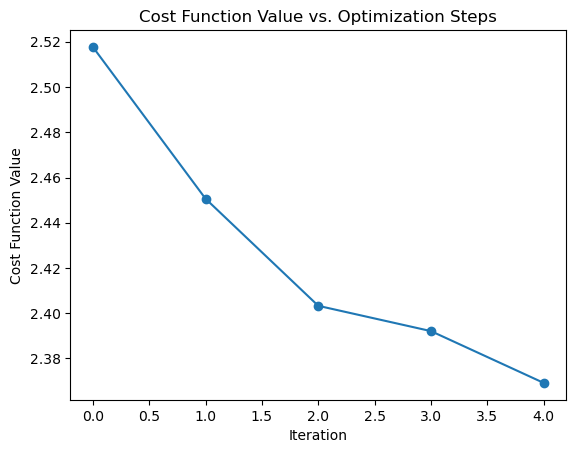

Optimization True
Optimal parameters: [-0.00018567  0.08968721  0.03436904 -0.03092754 -0.09889405 -0.00522747]
Sum of parameters: -0.011178474081137783
Objective function value: 2.3692770590809893


array([-0.00018567,  0.08968721,  0.03436904, -0.03092754, -0.09889405,
       -0.00522747])

In [76]:
HIGHEST_ORDER = 6
init_temp_coeff = 1/10
T_range = 150
L_range = 30
N_particle = 1000
survival_weight = 0.8


init_guess = np.array([-0.00538719,  0.0996388 ,  0.00868887, -0.00868887, -0.0996388 , 0.00538719])
init_cost = loss_func(init_guess, N_particle, HIGHEST_ORDER, init_temp_coeff, T_range, L_range, survival_weight)
print(f"initial cost = {init_cost}")

# Initialize a list to store the cost function values
cost_values = []
# Define the callback function
def callback(xk):
    cost_values.append(loss_func(xk,N_particle, HIGHEST_ORDER, init_temp_coeff, T_range, L_range, survival_weight))
# constraints = [{'type': 'eq', 'fun': lambda x: x[0]**2 + x[-1]**2}]
result = minimize(loss_func, init_guess, args=(N_particle, HIGHEST_ORDER, init_temp_coeff, T_range, L_range, survival_weight),\
                   method='Powell', options={'maxiter':500, 'disp': True}, callback=callback)

# result = basinhopping(loss_func, init_guess, 
#                       minimizer_kwargs={method='Nelder-Mead', 
#                     args=(N_particle, HIGHEST_ORDER, init_temp_coeff, T_range, L_range, 0.8)},
#                       niter=10, stepsize=0.2,disp=True)

# Plot the cost function values
plt.plot(cost_values, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Cost Function Value')
plt.title('Cost Function Value vs. Optimization Steps')
plt.show()
print(f"Optimization {result.success}")
print("Optimal parameters:", result.x)
print("Sum of parameters:", np.sum(result.x))
print("Objective function value:", result.fun)

result.x

initial cost = 2.4021313167417726
Optimization terminated successfully.
         Current function value: 2.312130
         Iterations: 2
         Function evaluations: 195


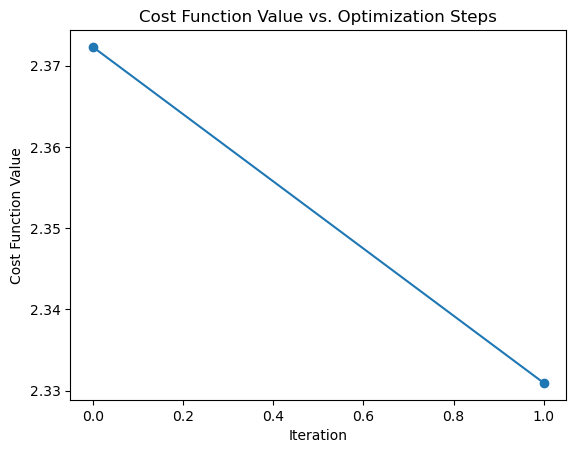

Optimization True
Optimal parameters: [ 0.06846587  0.03726881  0.04533256 -0.09150847 -0.04486716]
Sum of parameters: 0.01469160928480627
Objective function value: 2.3121304086492596


array([ 0.06846587,  0.03726881,  0.04533256, -0.09150847, -0.04486716])

In [11]:
HIGHEST_ORDER = 5
init_temp_coeff = 1/10
T_range = 150
L_range = 30
N_particle = 1000
survival_weight = 0.8


init_guess = np.array([ 0.06838189,  0.03016895,  0.03405778, -0.10034434, -0.04302827])

init_cost = loss_func(init_guess, N_particle, HIGHEST_ORDER, init_temp_coeff, T_range, L_range, survival_weight)
print(f"initial cost = {init_cost}")

# Initialize a list to store the cost function values
cost_values = []
# Define the callback function
def callback(xk):
    cost_values.append(loss_func(xk,N_particle, HIGHEST_ORDER, init_temp_coeff, T_range, L_range, survival_weight))
# constraints = [{'type': 'eq', 'fun': lambda x: x[0]**2 + x[-1]**2}]
result = minimize(loss_func, init_guess, args=(N_particle, HIGHEST_ORDER, init_temp_coeff, T_range, L_range, survival_weight),\
                   method='Powell', options={'maxiter':500, 'disp': True}, callback=callback)

# result = basinhopping(loss_func, init_guess, 
#                       minimizer_kwargs={method='Nelder-Mead', 
#                     args=(N_particle, HIGHEST_ORDER, init_temp_coeff, T_range, L_range, 0.8)},
#                       niter=10, stepsize=0.2,disp=True)

# Plot the cost function values
plt.plot(cost_values, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Cost Function Value')
plt.title('Cost Function Value vs. Optimization Steps')
plt.show()
print(f"Optimization {result.success}")
print("Optimal parameters:", result.x)
print("Sum of parameters:", np.sum(result.x))
print("Objective function value:", result.fun)

result.x

In [9]:
temp = np.array([-0.01550101,  0.07998426,  0.00532287, -0.01205487, -0.11929333,-0.00472664])
temp = np.array([0,  0.10293898,  0.04185758, -0.02090213, -0.09836886,0])
temp = np.array([-0.00018567,  0.08968721,  0.03436904, -0.03092754, -0.09889405,-0.00522747])
temp=np.array([ 0.06838189,  0.03016895,  0.03405778, -0.10034434, -0.04302827])

temp_inv = -temp[::-1]
(temp + temp_inv)/2

array([ 0.05570508,  0.06525665,  0.        , -0.06525665, -0.05570508])

In [84]:
0.31 * np.array([-0.00538719,  0.0996388 ,  0.00868887, -0.00868887, -0.0996388 , 0.00538719]) + 0.69 * np.array([ 0.0025209 ,  0.09429063,  0.03264829, -0.03264829, -0.09429063,-0.0025209 ])

array([ 6.93921000e-05,  9.59485627e-02,  2.52208698e-02, -2.52208698e-02,
       -9.59485627e-02, -6.93921000e-05])

5
[0, 0]


c:\Users\luyue\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


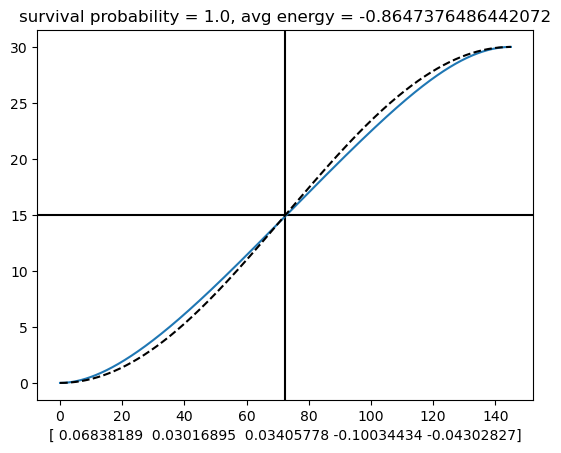

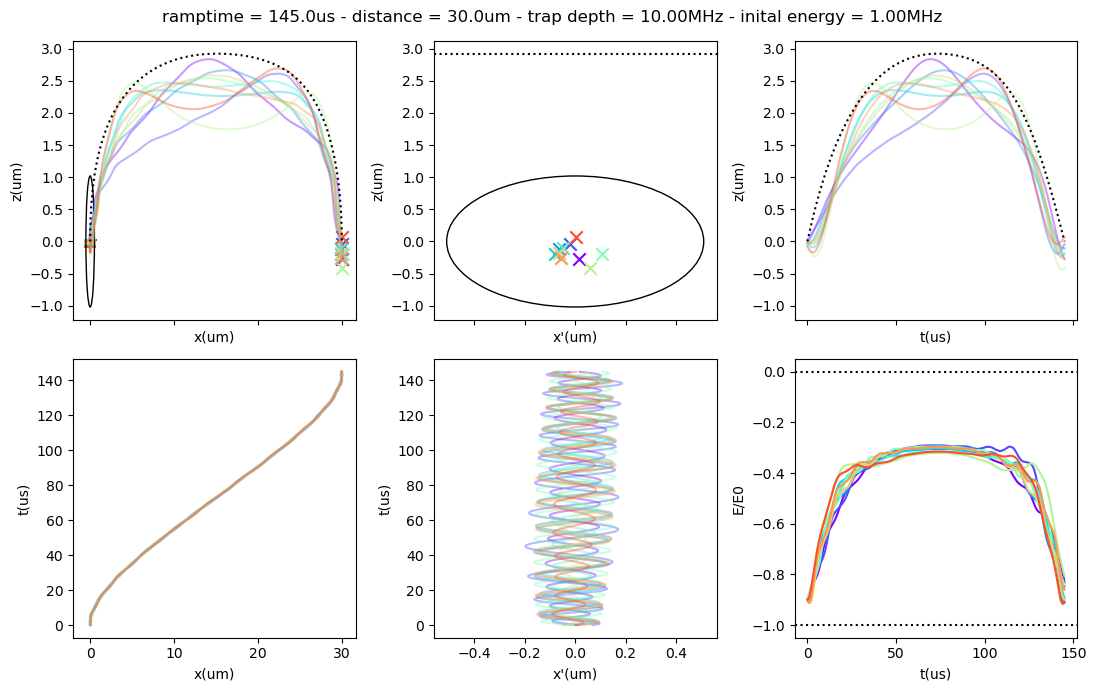

5
[0, 1]


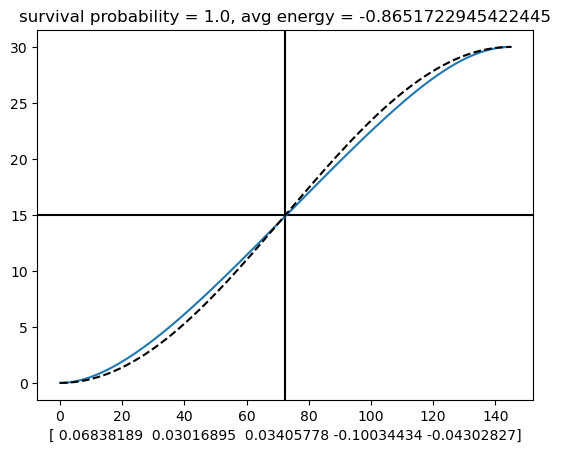

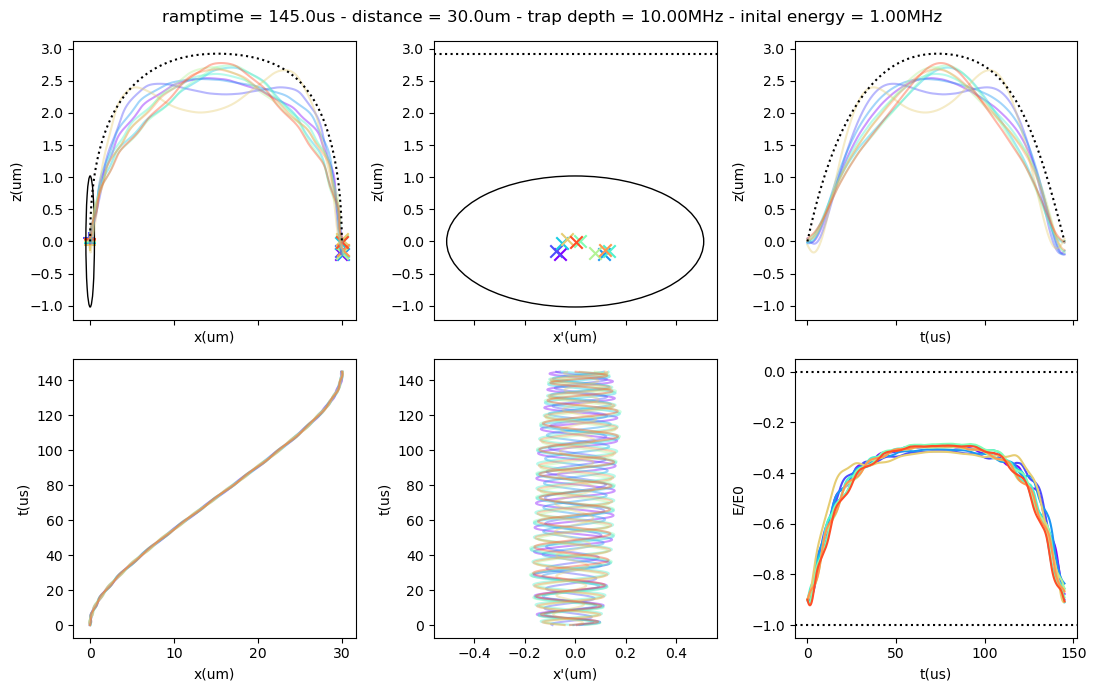

4
[0, 2]


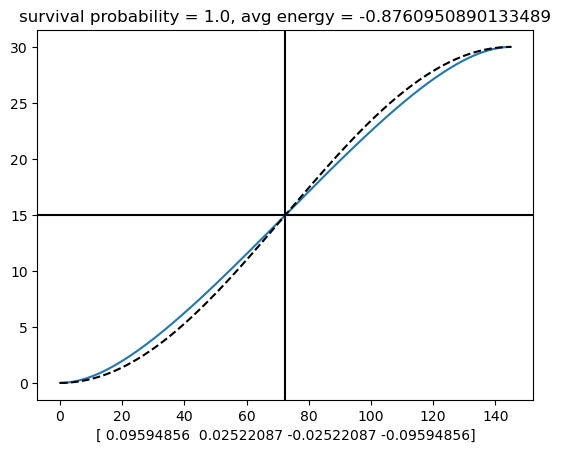

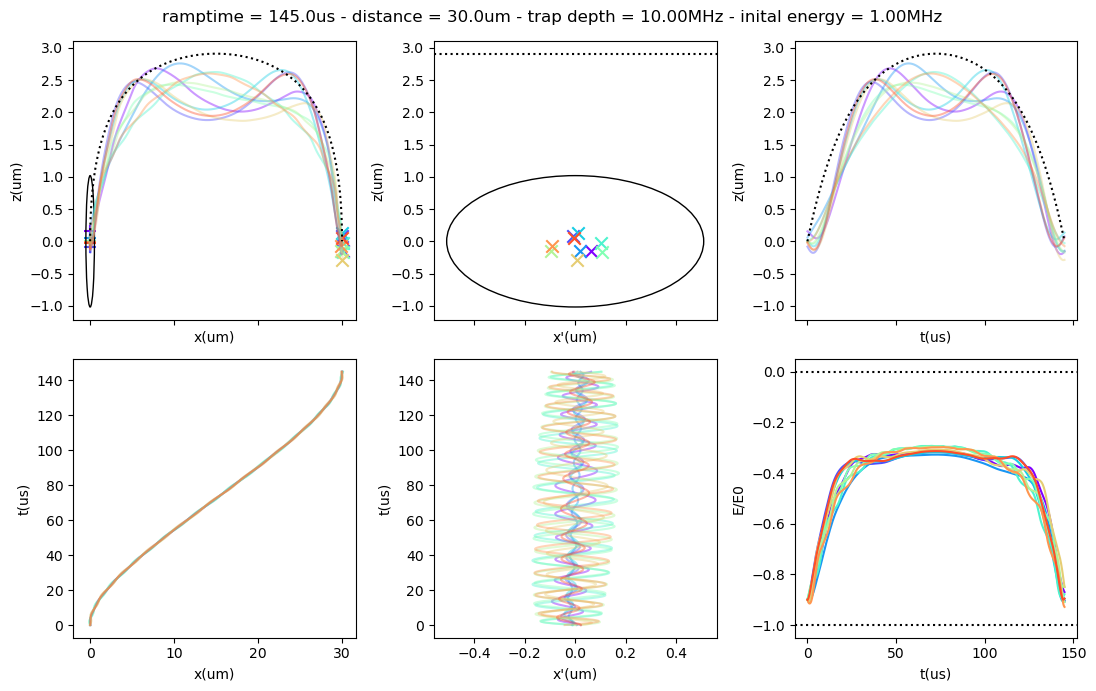

4
[0, 3]


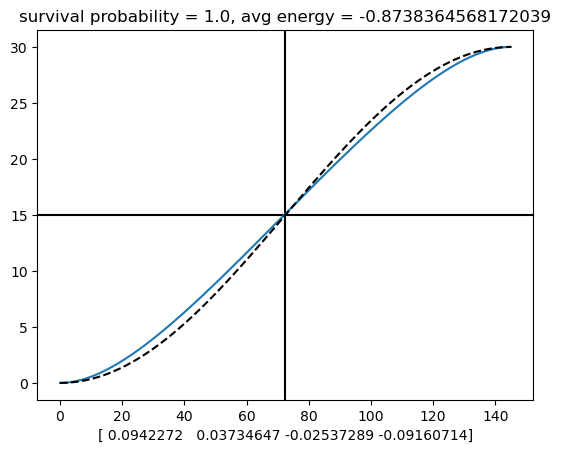

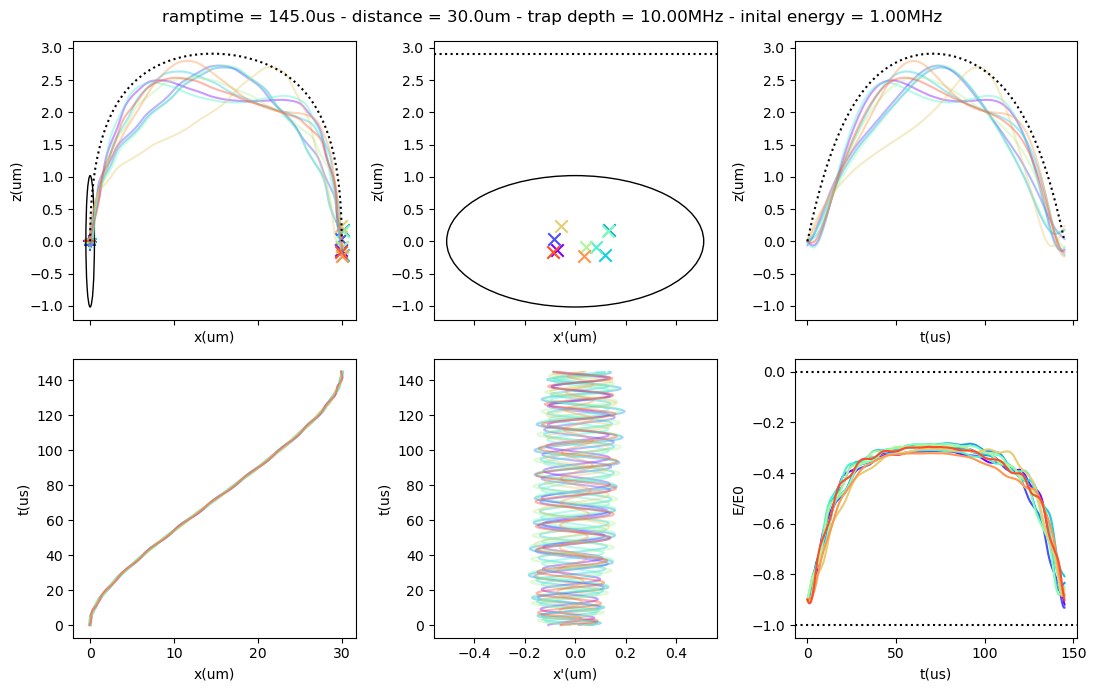

12
[0, 4]


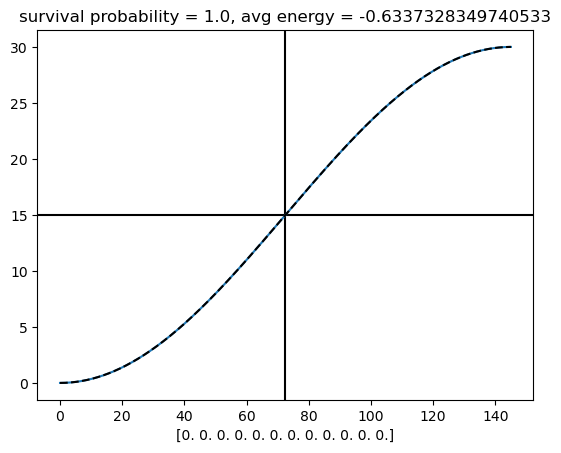

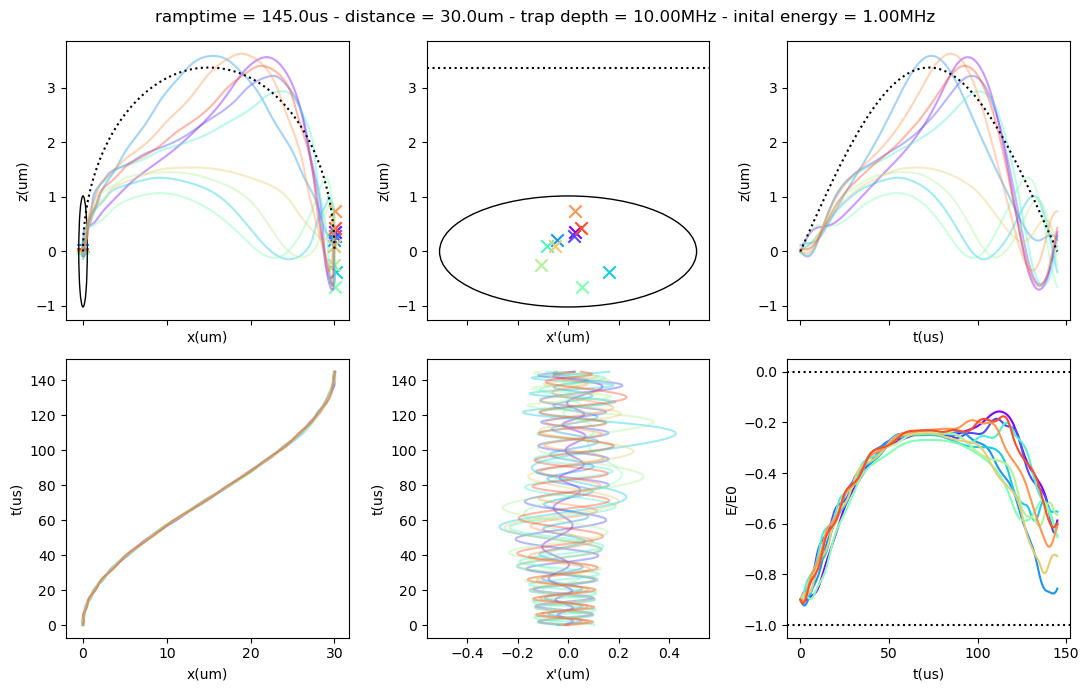

5
[1, 0]


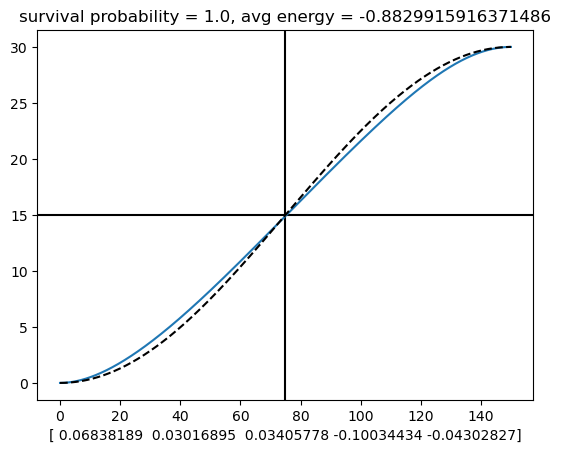

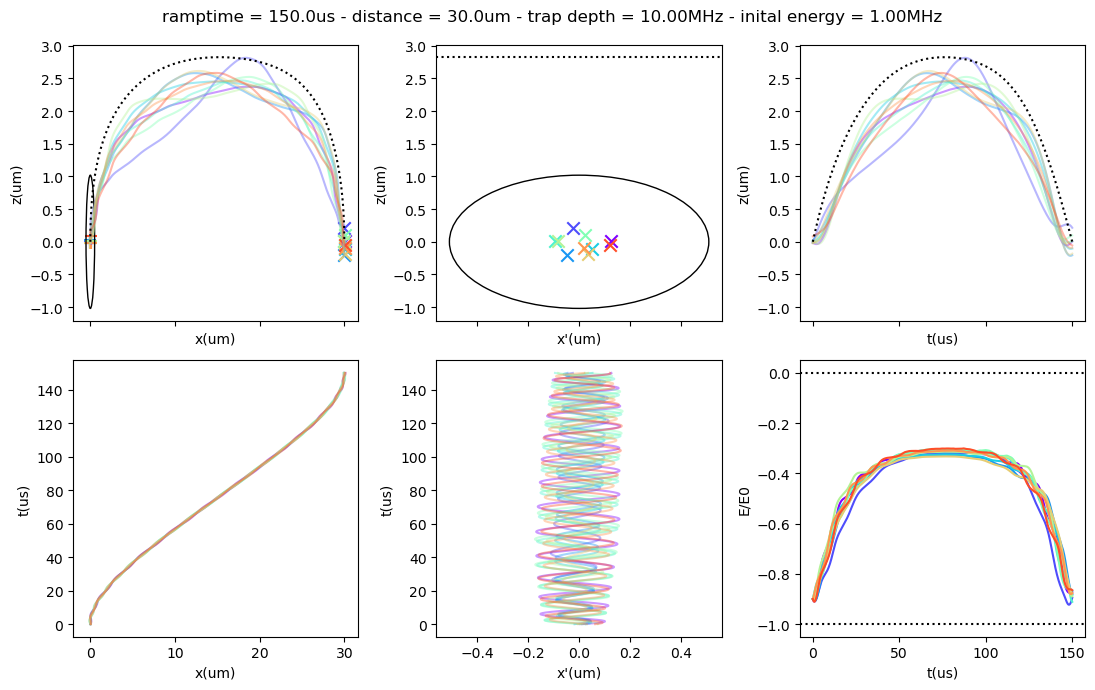

5
[1, 1]


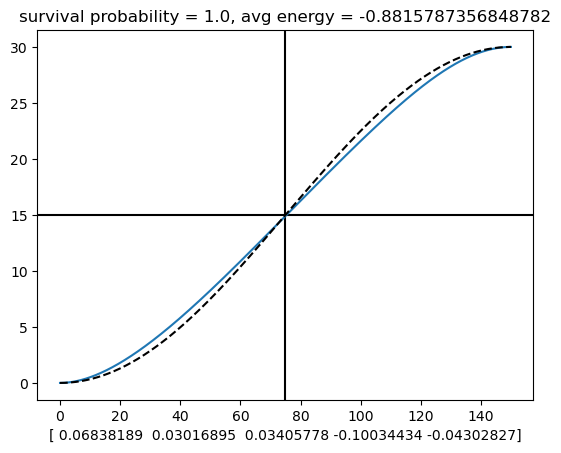

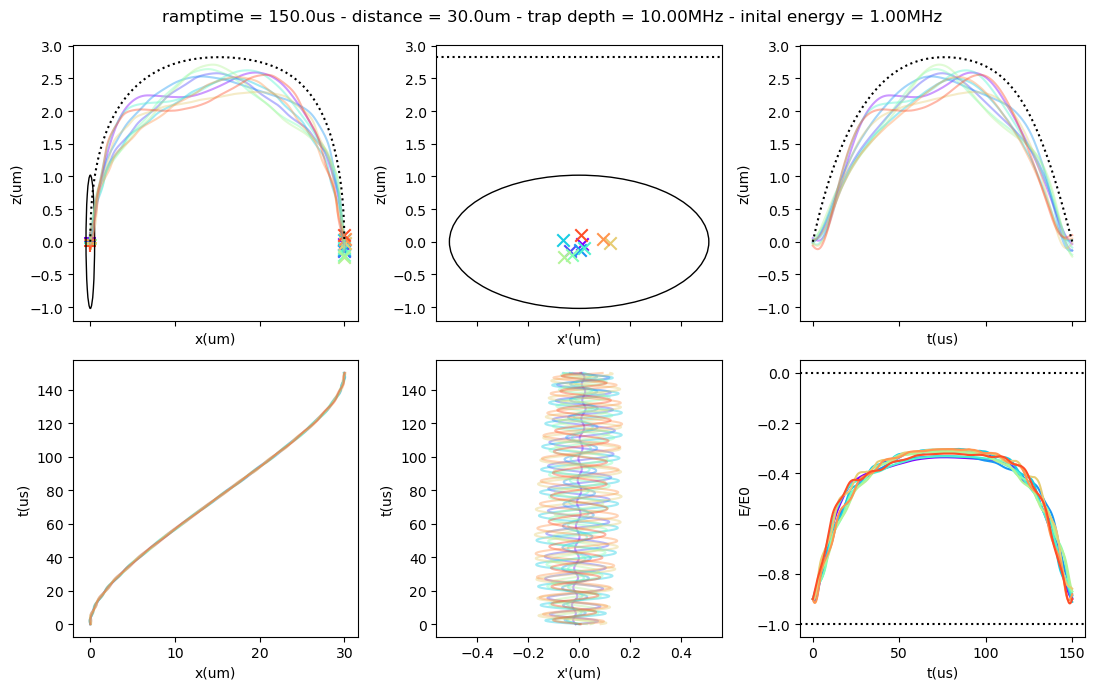

4
[1, 2]


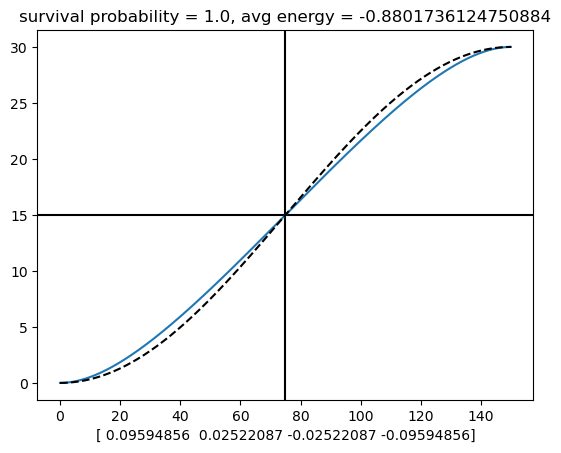

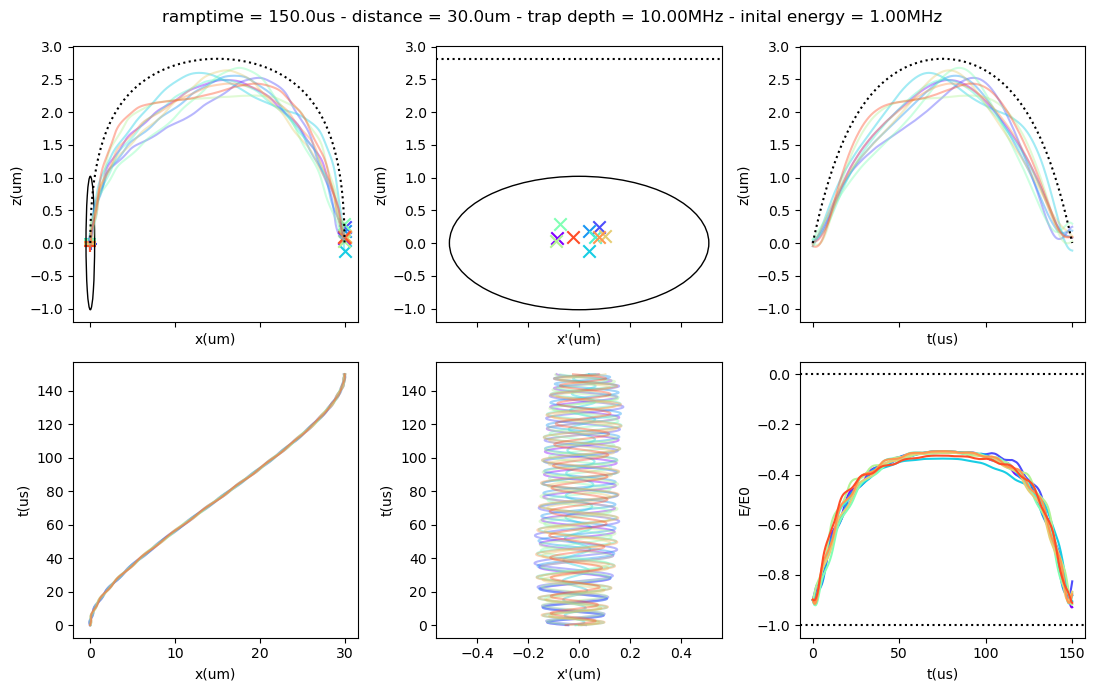

4
[1, 3]


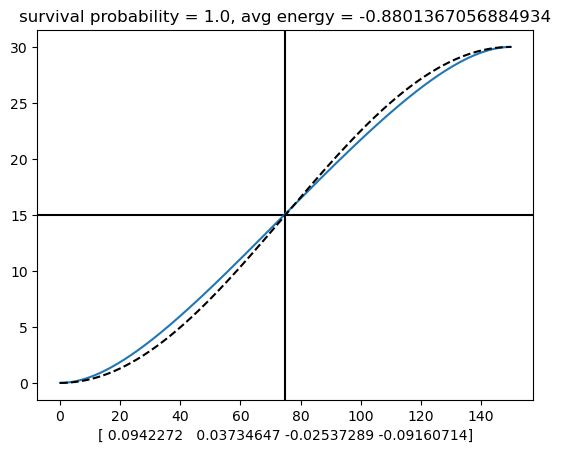

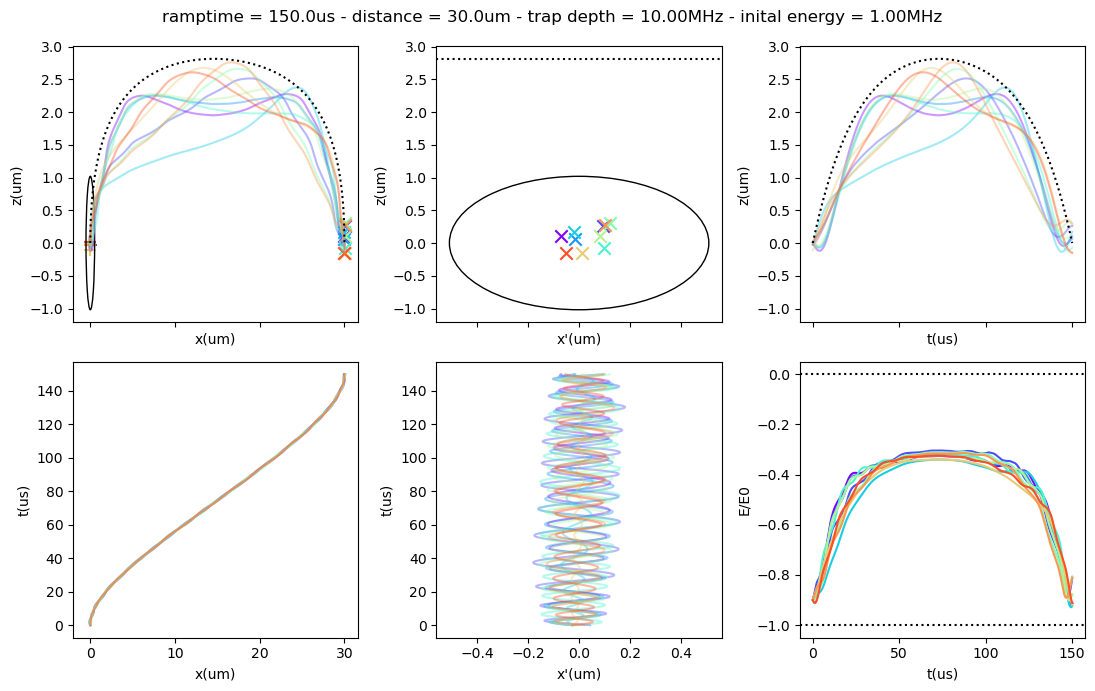

12
[1, 4]


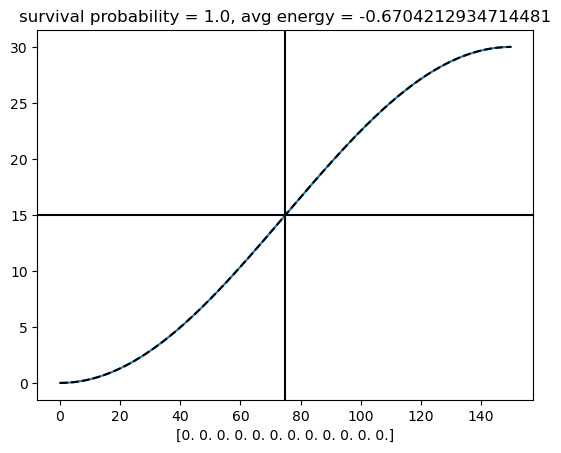

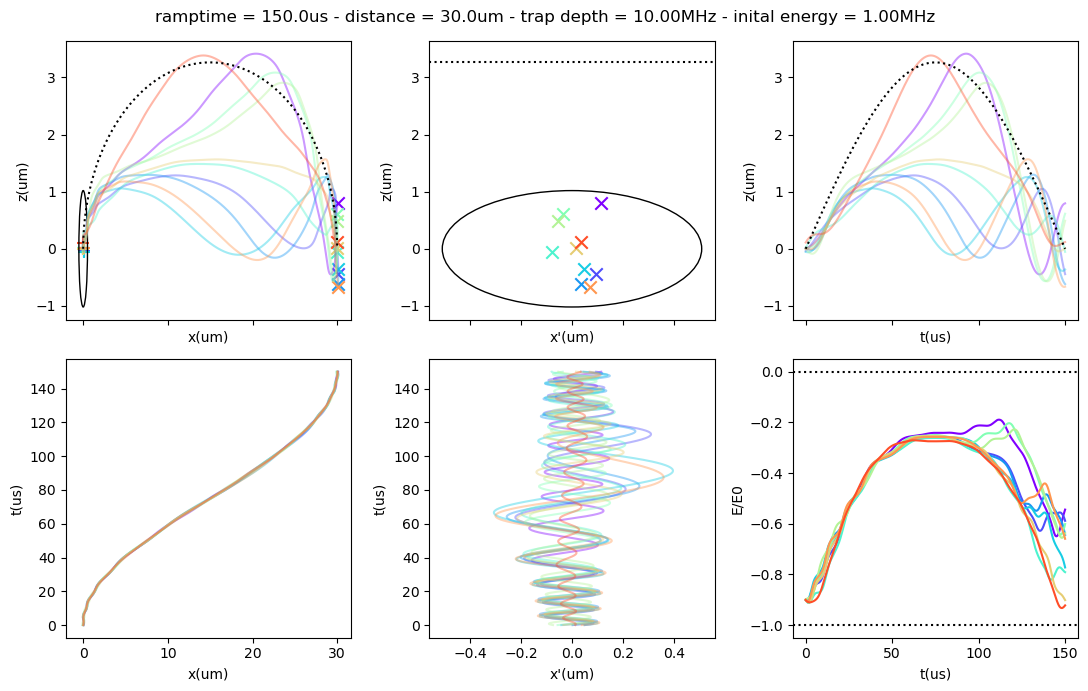

In [13]:
L_range = 30
plot_ramp = True
plot_trajectory = True
plot_histogram = False
N_particle = 500
HIGHEST_ORDER = 12

T_range_list = np.linspace(145,150,2) #us
sinc_order_list = [np.array([ 0.06838189,  0.03016895,  0.03405778, -0.10034434, -0.04302827])
    ,np.array([ 0.06838189,  0.03016895,  0.03405778, -0.10034434, -0.04302827])
                ,np.array([ 0.0959485627,  0.0252208698, -0.0252208698,-0.0959485627])
                   ,np.array([ 0.0942272 ,  0.03734647, -0.02537289, -0.09160714])
                   ,np.zeros(HIGHEST_ORDER)]
# sinc_order_list = [np.array([ 0,  9.59485627e-02,  2.52208698e-02, -2.52208698e-02,-9.59485627e-02, 0])
#                    ,np.array([ 0.0025209 ,  0.09429063,  0.03264829, -0.03264829, -0.09429063,-0.0025209 ])
#                    ,np.array([-0.00538719,  0.0996388 ,  0.00868887, -0.00868887, -0.0996388 , 0.00538719])
#                    ,np.zeros(HIGHEST_ORDER)]
# sinc_order_list = [np.array([0, 0.14270274, 0.06478582, 0.01260777, 0.00584343,0])
#             ,np.array([-0.01550101,  0.07998426,  0.00532287, -0.01205487, -0.11929333,-0.00472664])
#                     ,np.array([0, 0.07526053,  0.02253603, -0.0083004 , -0.16799033,0])
#                    ,np.array([0, 0.05325509,  0.05340441,  0.0407946 , -0.12021871, -0.09386017, 0])
#                    ,np.zeros(HIGHEST_ORDER)]

phase_vec_array = np.empty((len(T_range_list),len(sinc_order_list)), dtype=object)
t_vec_array = np.empty((len(T_range_list),len(sinc_order_list)), dtype=object)
energies_array = np.empty((len(T_range_list),len(sinc_order_list)), dtype=object)
survival_array = np.zeros((len(T_range_list),len(sinc_order_list)))
energy_avg_array = np.zeros((len(T_range_list),len(sinc_order_list)))
energy_std_array = np.zeros((len(T_range_list),len(sinc_order_list)))

init_temp = E0/10

for ii,T_range in enumerate(T_range_list):
    t_list = np.linspace(0,T_range,1000)
    for jj,expand_param in enumerate(sinc_order_list):
        HIGHEST_ORDER = len(expand_param)
        print(HIGHEST_ORDER)
        ##################################################################
        phase_vec_list = []
        t_vec_list = []

        ###################### vectorized simulation #####################
        init_vec = np.random.normal(0, np.sqrt(init_temp/3), (6,N_particle))
        init_vec[0:2] = init_vec[0:2]/np.sqrt(4*E0/W**2)
        init_vec[3] = init_vec[3]/np.sqrt(2*E0/ZR**2)
        init_vec[3:6] = init_vec[3:6]/np.sqrt(M)

        real_E = np.stack((total_energy_t0(init_vec),) * 6, axis=-1).T
        normalize_factor = init_temp/(real_E+E0)
        # print(normalize_factor.shape)
        # comment out the next line if use boltzmann distribution
        init_vec *= np.sqrt(normalize_factor)  
        init_vec_flattened = init_vec.ravel()
        t_eval = np.linspace(0,T_range,1000)
        sol1=solve_ivp(time_derivative, [0,T_range], init_vec_flattened,\
                        method='RK45', args=[expand_param], vectorized=True, t_eval=t_eval) #, maxes_step=.1)
        phase_vec_list = sol1.y.reshape(6,N_particle,-1).transpose(1, 0, 2)
        t_vec = sol1.t
        solutions = sol1.y.reshape(6,N_particle,-1) # [phase_vec_ind, particle_num, time]
        energy_t = np.array([total_energy_movframe(sol1.t, solutions[:,ii] ,expand_param)/E0 for ii in range(N_particle)])
        # print(energy_t.shape)
        energy_list = energy_t[:,-1]
        # print(energy_list.shape)
        # print(energy_list[0].shape)
        energies_array[ii,jj] = energy_list

        energy_std = np.std(energy_list)
        energy_avg = np.mean(energy_list)

        survival = sum(energy_list<0)/len(energy_list)

        energy_std_array[ii,jj] = energy_std
        energy_avg_array[ii,jj] = energy_avg
        survival_array[ii,jj] = survival
        phase_vec_array[ii,jj] = phase_vec_list
        t_vec_array[ii,jj] = t_vec_list
        
        print([ii,jj])
        if plot_ramp:
            plt.figure()
            # plt.title(n)
            plt.axvline(T_range/2,color='k')
            plt.axhline(L_range/2,color='k')
            plt.plot(t_list, xc_func(t_list,expand_param))
            plt.plot(t_list, xc_func_base(t_list),ls="--",c='k')
            plt.title(f"survival probability = {survival}, avg energy = {energy_avg}")
            plt.xlabel(expand_param)
            plt.show()

        if plot_trajectory:
            n=N_particle//50
            # Create a figure and a set of subplots
            fig, axes = plt.subplots(2,3,figsize=(11,7),sharex='col',sharey=False)
            fig.suptitle(f"ramptime = {T_range:.1f}us - distance = {L_range:.1f}um - trap depth = {E0/(TRAP_DEPTH_MHz / RB_MASS):.2f}MHz - inital energy = {init_temp/(TRAP_DEPTH_MHz / RB_MASS):.2f}MHz")

            for ax in axes[0, :]:
                ax.sharey(axes[0, 0])
            # Define the center of the oval, width, and height
            center_x, center_y = 0,0
            width, height = 2*W,2*ZR


            color = cm.rainbow(np.linspace(0, 0.9, n))

            for i,phase_vec in enumerate(phase_vec_list[:n]):
                axes[0,0].plot(phase_vec[0],phase_vec[2],color=color[i],alpha=0.4)
                axes[0,0].scatter(phase_vec[0,0],phase_vec[2,0],color=color[i],marker="+",s=80)
                axes[0,0].scatter(phase_vec[0,-1],phase_vec[2,-1],color=color[i],marker="x",s=80)
                axes[0,0].set_xlabel("x(um)")
                axes[0,0].set_ylabel("z(um)")
                axes[1,0].plot(phase_vec[0],t_vec,color=color[i],alpha=0.4)
                axes[1,0].set_xlabel("x(um)")
                axes[1,0].set_ylabel("t(us)")
                # axes[0,1].plot(phase_vec[0]-xc_func(t_vec,expand_param),phase_vec[2],color=color[i],alpha=0.4)
                # axes[0,1].scatter(phase_vec[0,0],phase_vec[2,0],color=color[i],marker="+",s=80)
                axes[0,1].scatter(phase_vec[0,-1]-xc_func(t_vec[-1],expand_param),phase_vec[2,-1],color=color[i],marker="x",s=80)
                axes[0,1].set_xlabel("x'(um)")
                axes[0,1].set_ylabel("z(um)")
                axes[1,1].plot(phase_vec[0]-xc_func(t_vec,expand_param),t_vec,color=color[i],alpha=0.4)
                axes[1,1].set_xlabel("x'(um)")
                axes[1,1].set_ylabel("t(us)")
                axes[0,2].plot(t_vec,phase_vec[2],color=color[i],alpha=0.4)
                axes[0,2].set_xlabel("t(us)")
                axes[0,2].set_ylabel("z(um)")
                axes[1,2].plot(t_vec, total_energy_movframe(t_vec, phase_vec, expand_param)/E0, color=color[i])
                
            axes[0,2].plot(t_vec, Zx_func(t_vec,expand_param),color="k",ls=":")
            axes[1,2].axhline(0, color="k",ls=":")
            axes[1,2].axhline(-1, color="k",ls=":")
            axes[1,2].set_xlabel("t(us)")
            axes[1,2].set_ylabel("E/E0")
            
            # Create an ellipse patch
            ellipse = patches.Ellipse((center_x, center_y), width, height, edgecolor='black', facecolor='none')
            ellipse2 = patches.Ellipse((center_x, center_y), width, height, edgecolor='black', facecolor='none')

            # Add the ellipse to the plot
            axes[0,0].add_patch(ellipse)
            # axes[0,0].axhline(Zx_func(T_range/2,expand_param),color="k",ls=":")
            axes[0,0].plot(xc_func(t_vec,expand_param), Zx_func(t_vec,expand_param),color="k",ls=":")
            axes[0,1].add_patch(ellipse2)
            axes[0,1].axhline(Zx_func(T_range/2,expand_param),color="k",ls=":")

            plt.tight_layout()
            plt.show()

        # energy_list = np.array([total_energy(t_vec, phase_vec_list[i],expand_param)[-1]/E0 for i in range(len(t_vec_list))])


        if plot_histogram:
            plt.figure()
            # plt.title(n)
            plt.axvline(0,color='k')
            plt.hist(energy_list, bins=30, edgecolor='black')
            plt.title(f"survival probability = {survival}, avg energy = {energy_avg}")
            plt.xlabel(expand_param)
            plt.show()
            
        #################################################################################

# print(f"survival probability = {sum(energy_list<0)/len(energy_list)}")